In [1]:
from keras.models import load_model
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
%matplotlib inline

Using TensorFlow backend.


## Library

In [2]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        list_files = os.listdir(os.path.join(path, i))
        if len(list_files) > 10:
            for f in list_files:
                # Check file extension. Allow only jpg/jpeg' files.
                ext = os.path.splitext(f)[1]
                if ext == '.jpg' or ext == '.jpeg':
                    metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

## Loading model

In [3]:
#memuat model
model = load_model('food_ai_model.hdf5',compile=False)
metadata = load_metadata('food101/test/')
print(f'Test data: {len(metadata)}')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Test data: 25420


## Evaluasi 

In [4]:
def recognize(img):
    prediction = model.predict(np.expand_dims(img, axis=0))[0]

    return prediction

In [ ]:
import pyprind


labels = pickle.load(open('label/label_encode','rb'))
y_pred = []

bar = pyprind.ProgBar(len(metadata),monitor=True, title='Proses Pengujian')
for data in metadata:
    path = data.image_path()
    img = load_img(path, target_size=(299, 299))
    img = img_to_array(img)
    pred = recognize(img)
    label = labels[np.argmax(pred)]
    y_pred.append(label)
    bar.update()
print(bar)

Proses Pengujian
0% [#######                       ] 100% | ETA: 01:42:36

## Akurasi 

In [6]:
y_true = [data.name for data in metadata]

true_count = 0
for true, pred in zip(y_true, y_pred):
    if true == pred:
        true_count += 1
        
acc = (true_count/len(y_true)) * 100
print(f'Overall Accuracy: {acc}%')

Overall Accuracy: 84.29583005507475%


## Library Confusion Matrix

In [7]:
#library cnf_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas_ml import ConfusionMatrix

In [8]:
%%time
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

Wall time: 0 ns


Confusion Matrix, Tanpa Normalisasi
[[169   0   6 ...   1   0   4]
 [  0 226   0 ...   0   0   0]
 [  7   0 227 ...   0   0   0]
 ...
 [  1   2   1 ... 191   0   1]
 [  0   0   0 ...   0 187   0]
 [  2   0   0 ...   0   0 224]]


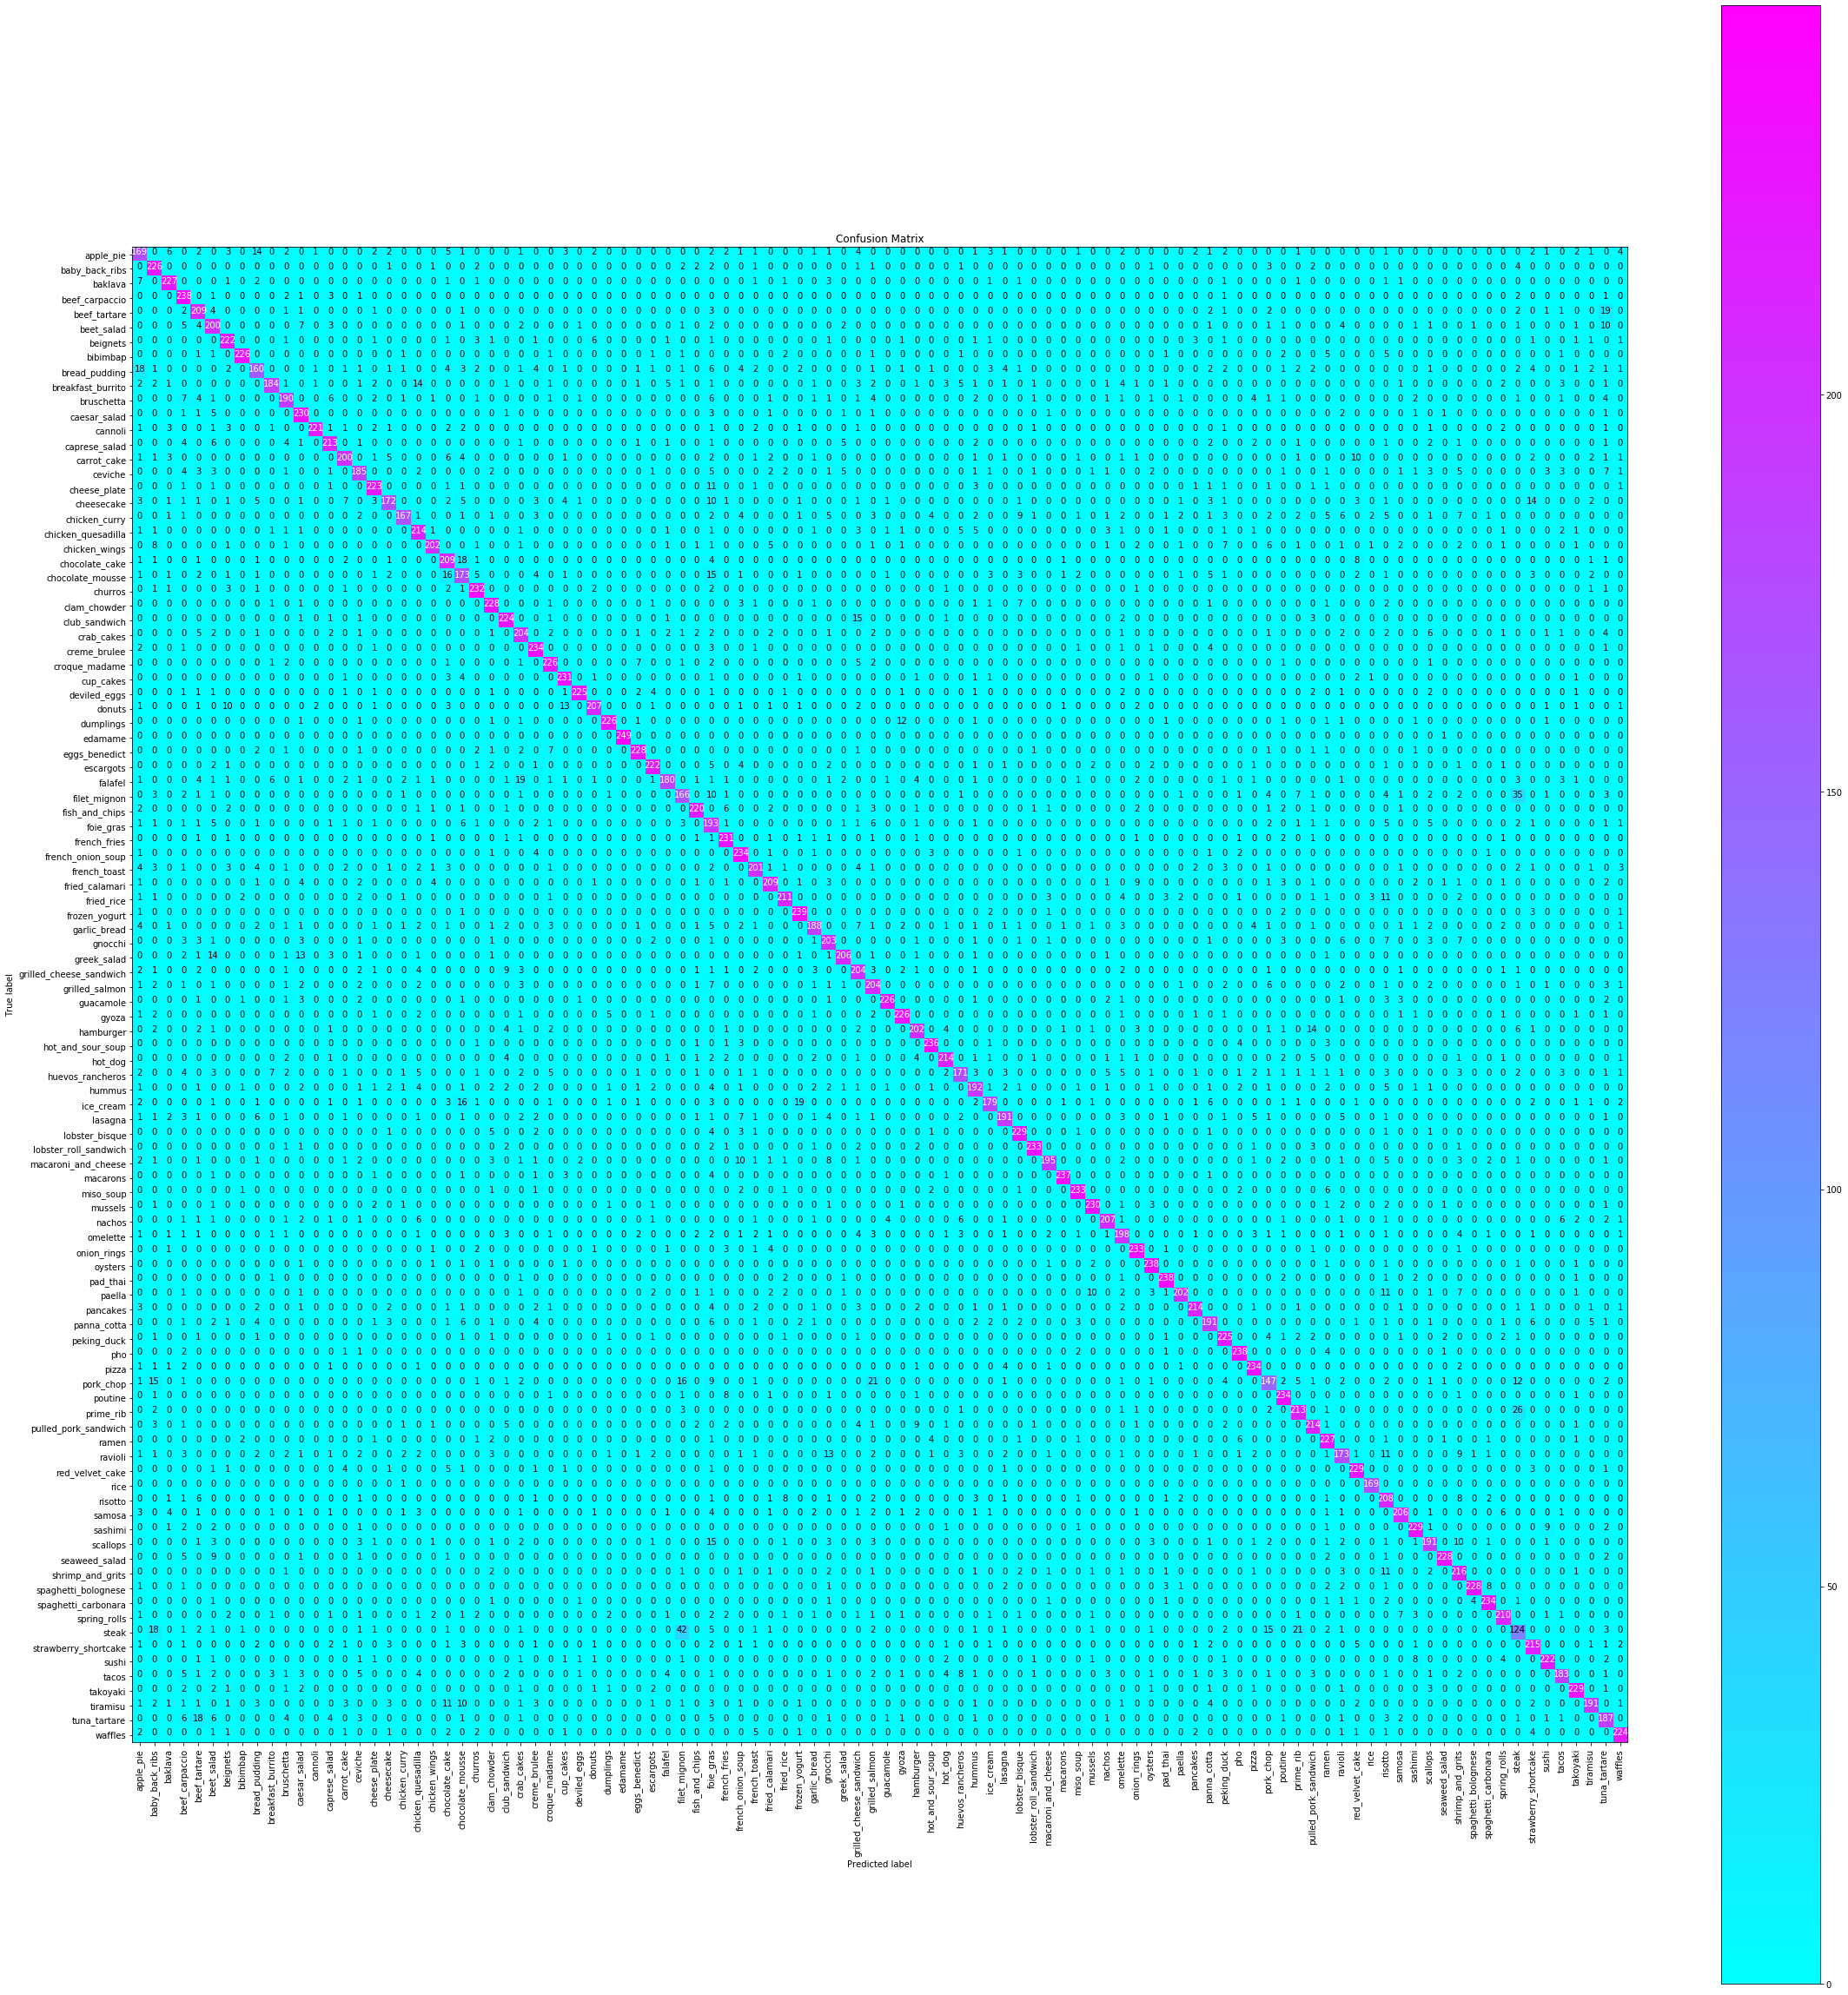

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    fungsi ini akan buat plot confusion matrix. 
    jk normalisasi, set `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion Matrix, Normalisasi")
    else:
        print('Confusion Matrix, Tanpa Normalisasi')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# hitungan
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

class_names = labels

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix',
                      cmap=plt.cm.cool)
plt.show()

In [10]:
print(classification_report(y_true, y_pred, labels=labels))

                         precision    recall  f1-score   support

              apple_pie       0.67      0.68      0.67       250
         baby_back_ribs       0.75      0.90      0.82       250
                baklava       0.88      0.91      0.90       250
         beef_carpaccio       0.74      0.95      0.83       250
           beef_tartare       0.73      0.84      0.78       250
             beet_salad       0.69      0.80      0.74       250
               beignets       0.85      0.89      0.87       250
               bibimbap       0.97      0.90      0.93       250
          bread_pudding       0.74      0.64      0.69       250
      breakfast_burrito       0.88      0.74      0.80       250
             bruschetta       0.83      0.76      0.79       250
           caesar_salad       0.80      0.92      0.86       250
                cannoli       0.98      0.88      0.93       250
          caprese_salad       0.86      0.85      0.85       250
            carrot_cake 

In [11]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# sensitivitas atau true positive rate
TPR = TP/(TP+FN)
# spesifisitas atau true negative rate
TNR = TN/(TN+FP) 
# presisi 
PPV = TP/(TP+FP)
# nilai prediksi negatif
NPV = TN/(TN+FN)
# false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# akurasi keseluruhan
ACC = (TP+TN)/(TP+FP+FN+TN)

In [12]:
print(TPR)

[0.68 0.9  0.91 0.95 0.84 0.8  0.89 0.9  0.64 0.74 0.76 0.92 0.88 0.85
 0.8  0.74 0.89 0.69 0.67 0.86 0.81 0.84 0.69 0.93 0.91 0.9  0.82 0.94
 0.9  0.92 0.9  0.83 0.9  1.   0.91 0.89 0.72 0.66 0.88 0.77 0.92 0.94
 0.8  0.84 0.84 0.96 0.75 0.81 0.82 0.82 0.82 0.9  0.9  0.81 0.94 0.86
 0.68 0.77 0.72 0.76 0.92 0.93 0.78 0.95 0.93 0.92 0.83 0.79 0.93 0.95
 0.95 0.81 0.86 0.76 0.9  0.95 0.94 0.59 0.94 0.85 0.86 0.91 0.69 0.92
 0.99 0.83 0.82 0.92 0.76 0.91 0.86 0.91 0.94 0.84 0.5  0.86 0.89 0.73
 0.92 0.76 0.75 0.9 ]


In [ ]:
print(ACC)

In [ ]:
print(TNR)

In [ ]:
print(PPV)

In [ ]:
print(NPV)

In [ ]:
print(FPR)

In [ ]:
print(FNR)

In [ ]:
print(FDR)